# Starter Notebook: Economic Well-Being Prediction Challenge

Welcome! This starter notebook is designed to get you started on this challenge, where you will be attempting to predict a measure of wealth for different locations across Africa. We will take a look at the data, create a model and then use that to make our first submission. After that we will briefly look at some ways to improve. Let's get started.

# Loading the Data

We're using the pandas library to load the data into dataframes - a tabular data structure that is perfect for this kind of work. Each of the three CSV files from Zindi is loaded into a dataframe and we take a look at the shape of the data (number of rows and columns) as well as a preview of the first 5 rows to get a feel for what we're working with.

In [1]:
import pandas as pd
import numpy as np
from IPython.core.display import display
from sklearn import model_selection

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
train = pd.read_csv('/content/gdrive/MyDrive/Projects/zindi/Train.csv')
print(train.shape)
train.head()

(21454, 19)


,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
0,ID_AAIethGy,Ethiopia,2016,R,0.0,0.000000,0.000000,0.000055,0.000536,0.999408,12.146134,25.489659,0.879484,0.000000,0.000000,0.000000,278.788451,769.338378,0.132783
1,ID_AAYiaCeL,Ethiopia,2005,R,0.0,0.000000,0.000110,0.000000,0.000018,0.999872,113.806716,64.136053,0.601427,0.000000,0.005427,0.000000,200.986978,337.135243,0.004898
2,ID_AAdurmKj,Mozambique,2009,R,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.400096,0.131900,0.000000,0.003078,0.000000,642.594208,169.913773,0.097320
3,ID_AAgNHles,Malawi,2015,R,0.0,0.000141,0.000181,0.000254,0.000228,0.999195,5.213320,25.379371,2.017136,11.293841,0.131035,0.000000,365.349451,613.591610,0.304107
4,ID_AAishfND,Guinea,2012,U,0.0,0.011649,0.017560,0.017383,0.099875,0.853533,31.734661,5.081620,22.815984,0.005047,0.130475,1.461894,222.867189,192.926363,0.605328


In train, we have a set of inputs (like 'urban_or_rural' or 'ghsl_water_surface') and our desired output variable, 'Target'. There are 21454 rows - lots of juicy data!

In [4]:
test = pd.read_csv('/content/gdrive/MyDrive/Projects/zindi/Test.csv')
print(test.shape)
test.head()

(7194, 18)


,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline
0,ID_AAcismbB,Democratic Republic of Congo,2007,R,0.000000,0.000000,0.000000,0.000523,0.000131,0.999347,0.660758,0.990942,0.132264,0.069055,0.032627,0.000000,1249.294720,1364.592100
1,ID_AAeBMsji,Democratic Republic of Congo,2007,U,0.000000,0.004239,0.000238,0.001227,0.002860,0.991437,6.441547,5.461365,0.452400,0.000000,0.000000,0.000000,821.019579,1046.028681
2,ID_AAjFMjzy,Uganda,2011,U,0.007359,0.525682,0.132795,0.095416,0.042375,0.196373,587.516458,2.881811,87.387991,3.248483,3.950374,60.070041,3.620455,906.057334
3,ID_AAmMOEEC,Burkina Faso,2010,U,0.000000,0.000089,0.000036,0.001519,0.001358,0.996997,35.141762,33.878927,4.166437,0.000000,0.130727,1.333999,109.493969,775.139189
4,ID_ABguzDxp,Zambia,2007,R,0.000000,0.000138,0.000623,0.000615,0.002961,0.995663,3.442449,33.491994,3.437129,0.133563,0.128997,0.502203,133.643319,835.591501


Test looks just like train but without the 'Target' column and with fewer rows.

In [5]:
ss = pd.read_csv('/content/gdrive/MyDrive/Projects/zindi/SampleSubmission.csv')
print(ss.shape)
ss.head()

(7194, 2)


,ID,Target
0,ID_AAcismbB,0
1,ID_AAeBMsji,0
2,ID_AAjFMjzy,0
3,ID_AAmMOEEC,0
4,ID_ABguzDxp,0


The sample submission is just the ID column from test with a 'Target' column where we will put out predictions.

Now that we have the data loaded, we can start exploring.

# EDA

We will explore some trends in the data and look for any anomalies such as missing data. A few examples are done here but you can explore much further yourself and get to know the data better.

First up: let's see how an input like 'nighttime lights' relates to the target column:

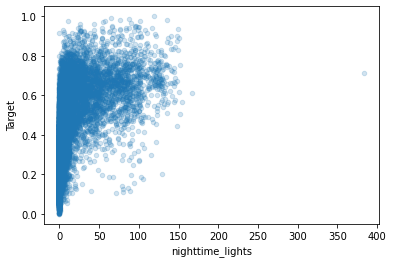

In [6]:
# Plotting the relationship between an input column and the target
train.plot(x='nighttime_lights', y='Target', kind='scatter', alpha=0.2)

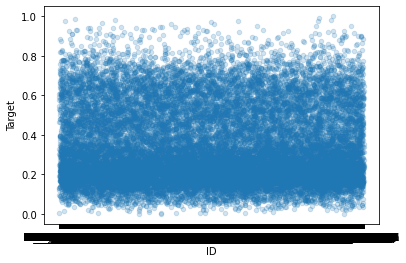

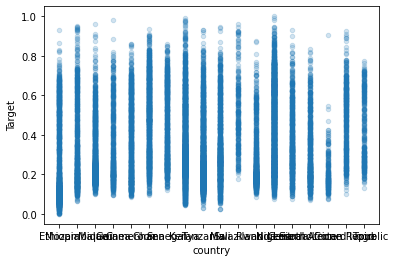

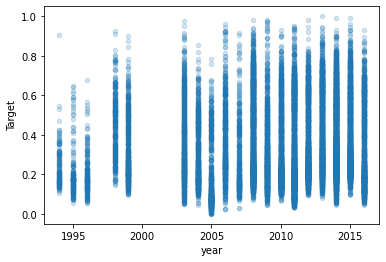

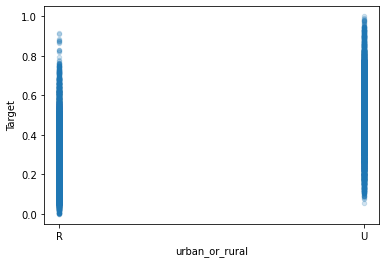

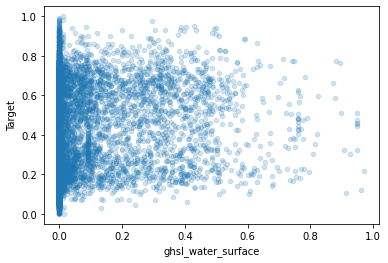

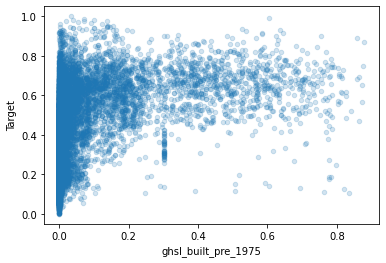

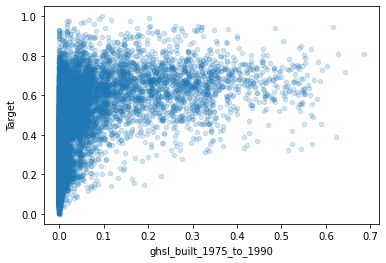

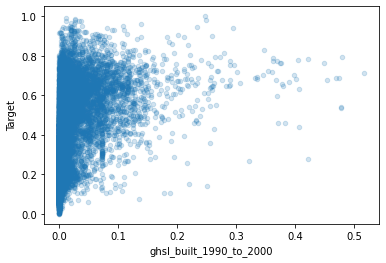

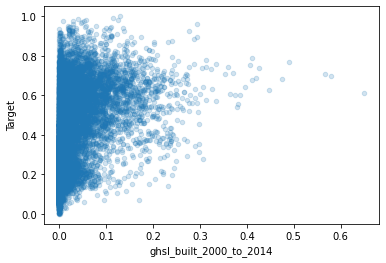

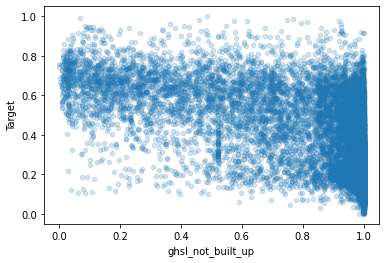

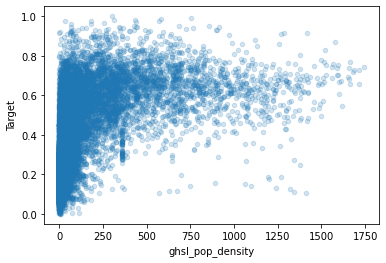

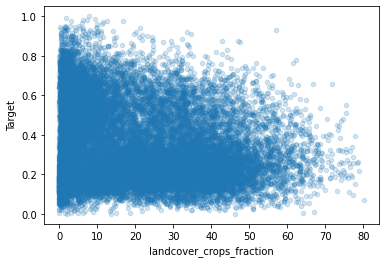

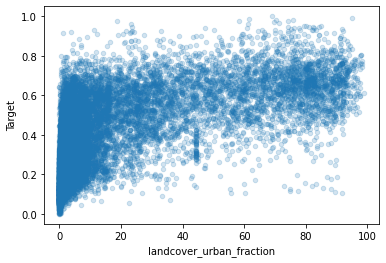

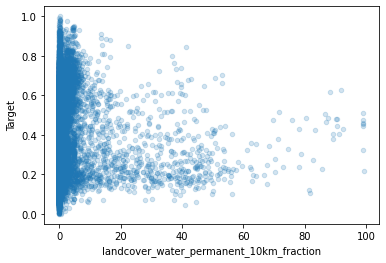

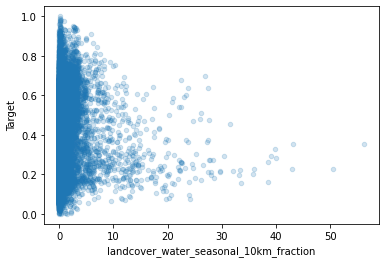

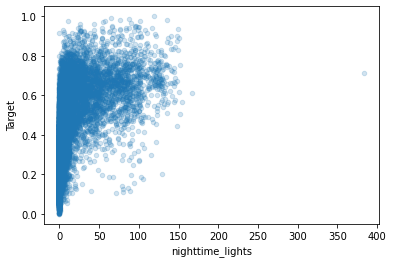

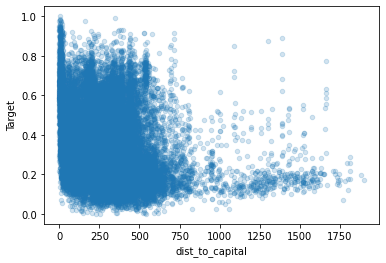

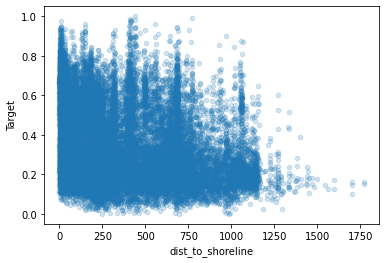

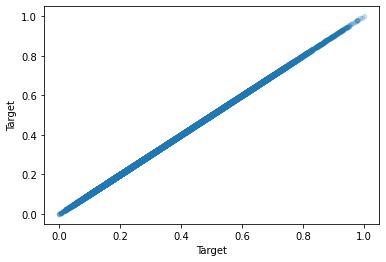

In [7]:
# Exercise: Try this with different inputs. Any unexpected trends?

for var in train.columns:
    train.plot(x=var, y='Target', kind='scatter', alpha=0.2)

As you might have guessed, places that emit more light tend to be wealthier, but there is a lot of variation.

We can also look at categorical columns like 'country' or 'urban_vs_rural' and see the distribution of the target for each group:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


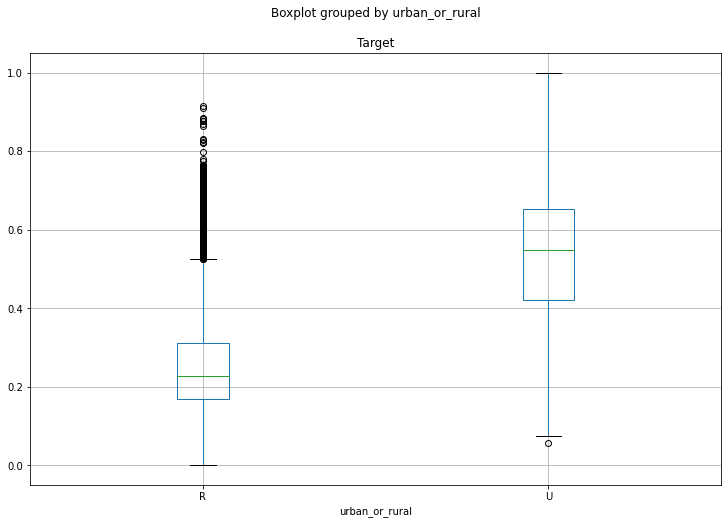

In [8]:
# Looking at the wealth distribution for urban vs rural
train.boxplot(by='urban_or_rural', column='Target', figsize=(12, 8))

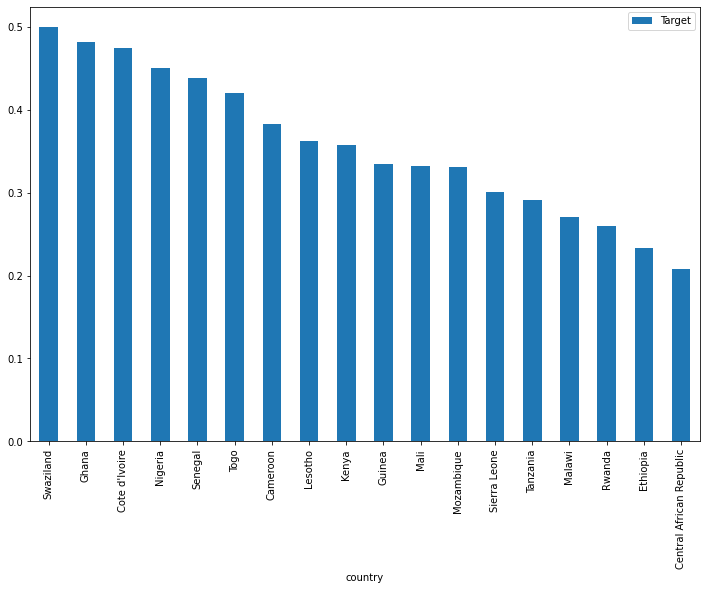

In [9]:
# Exercise: which is the country with the highest average wealth_index according to this dataset?

# to estimate this, we draw a barplot with x as country and y as target (wealth index)
country_df = train.groupby(['country'])['Target'].mean().reset_index()
country_df.sort_values(by='Target', ascending=False, inplace=True)
country_df.plot(x='country', y='Target', kind='bar', figsize=(12, 8))

The country with the highest average wealth_index according to this dataset is **Swaziland**.

Again, not unexpected. Rural areas tend to be less wealthy than urban areas.

Now the scary question: do we have missing data to deal with?

In [10]:
train.isna().sum() # Hooray - no missing data!

ID                                         0
country                                    0
year                                       0
urban_or_rural                             0
ghsl_water_surface                         0
ghsl_built_pre_1975                        0
ghsl_built_1975_to_1990                    0
ghsl_built_1990_to_2000                    0
ghsl_built_2000_to_2014                    0
ghsl_not_built_up                          0
ghsl_pop_density                           0
landcover_crops_fraction                   0
landcover_urban_fraction                   0
landcover_water_permanent_10km_fraction    0
landcover_water_seasonal_10km_fraction     0
nighttime_lights                           0
dist_to_capital                            0
dist_to_shoreline                          0
Target                                     0
dtype: int64

See what other trends you can uncover - we have only scratched the surface here. 

In [11]:
# Exercise: explore the data further

print("The data types in our dataset are: \n\n" + str(train.dtypes) + "\n\n")

The data types in our dataset are: 

ID                                          object
country                                     object
year                                         int64
urban_or_rural                              object
ghsl_water_surface                         float64
ghsl_built_pre_1975                        float64
ghsl_built_1975_to_1990                    float64
ghsl_built_1990_to_2000                    float64
ghsl_built_2000_to_2014                    float64
ghsl_not_built_up                          float64
ghsl_pop_density                           float64
landcover_crops_fraction                   float64
landcover_urban_fraction                   float64
landcover_water_permanent_10km_fraction    float64
landcover_water_seasonal_10km_fraction     float64
nighttime_lights                           float64
dist_to_capital                            float64
dist_to_shoreline                          float64
Target                                     fl

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0ddb82e50>,
      dtype=object)

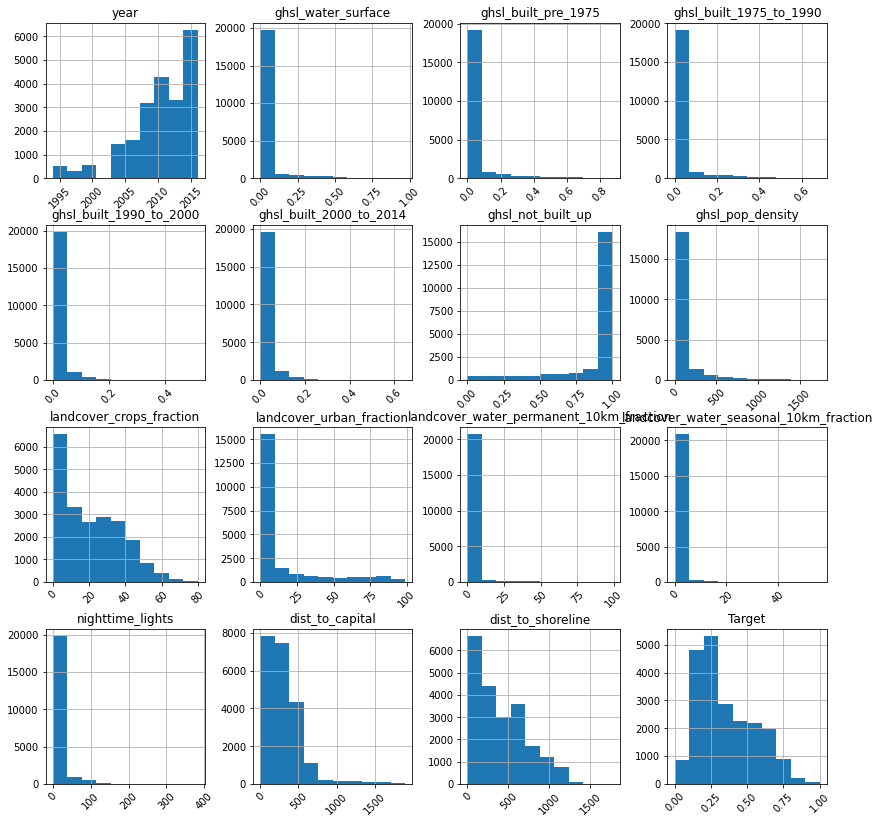

In [12]:
"""Distribution of values in the numerical variables to visualize the presence of outliers"""
train.hist(figsize=(14,14), xrot=45)

In [13]:
"""Summary statistics of the numerical variables"""
train.describe()

,year,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
count,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000
mean,2010.060874,0.028259,0.038222,0.028644,0.012689,0.018386,0.873800,95.756775,21.034265,13.999061,1.486849,0.714891,8.506543,289.722268,402.608539,0.350736
std,4.799579,0.097490,0.113562,0.077367,0.032745,0.040421,0.239294,209.704761,16.751106,23.715485,6.550171,2.383701,21.090378,238.811778,321.517285,0.194376
min,1994.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000859,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105306,0.112080,0.000000
25%,2008.000000,0.000000,0.000000,0.000000,0.000043,0.000124,0.897867,3.848533,5.610515,0.798841,0.000000,0.001325,0.000000,115.890873,126.379463,0.195772
50%,2011.000000,0.000000,0.000198,0.000709,0.001001,0.001871,0.991919,17.632672,18.509291,2.770159,0.000516,0.029151,0.137333,256.736472,327.271973,0.293574
75%,2014.000000,0.000000,0.007987,0.009868,0.008128,0.014936,0.999532,63.225683,33.590293,12.621501,0.152364,0.381969,4.830194,401.153071,643.910675,0.499003
max,2016.000000,0.969956,0.877116,0.685010,0.515534,0.649159,1.000000,1741.256516,80.064918,98.784092,99.164018,56.201637,382.932769,1897.351575,1769.523906,1.000000


In [14]:
"""Summary statistics of the categorical variables"""
train.describe(include="object")

,ID,country,urban_or_rural
count,21454,21454,21454
unique,21454,18,2
top,ID_EZqBVHbH,Nigeria,R
freq,1,2695,14061


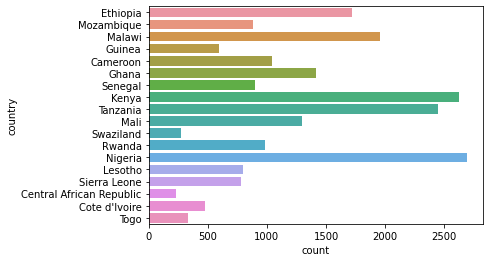

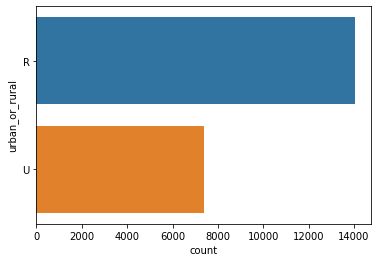

In [15]:
"""Let's also plot our categorical features. We'll only include variables with a small number of unique values"""
import seaborn as sns
import matplotlib.pyplot as plt

for column in train.select_dtypes(include='object'):
    if train[column].nunique() < 20:
        sns.countplot(y=column, data=train)
        plt.show()

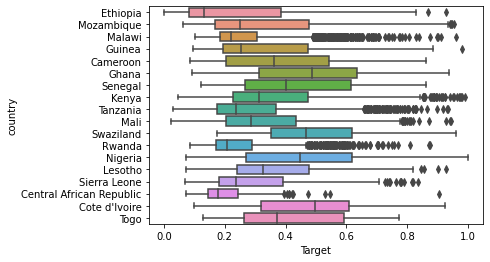

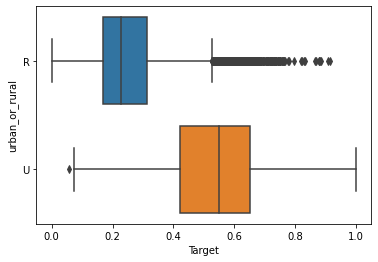

In [16]:
"""
Observing the relationship between our categorical and numerical features.
Let's see how our target compares to the categorical features. Again we will only use
categorical features with a small number of unique values.
"""

for column in train.select_dtypes(include='object'):
 if train[column].nunique() < 20:
     sns.boxplot(y=column, x='Target', data=train)
     plt.show()

In [17]:
"""
Observing the relationship between the categorical features and the other numerical features.
"""
for column in train.select_dtypes(include='object'):
    if train[column].nunique() < 20:
        display(train.groupby(column).agg(['mean','std']))

year            ...    Target          
                                 mean       std  ...      mean       std
country                                          ...                    
Cameroon                  2007.879923  3.480991  ...  0.382428  0.190676
Central African Republic  1994.389610  0.488721  ...  0.207962  0.097155
Cote d'Ivoire             2007.962578  6.114076  ...  0.474677  0.175932
Ethiopia                  2010.966299  4.482268  ...  0.233306  0.204022
Ghana                     2008.178295  6.721851  ...  0.481999  0.187371
Guinea                    2005.576728  6.505034  ...  0.334539  0.185659
Kenya                     2011.597106  4.153151  ...  0.357764  0.180494
Lesotho                   2011.584383  2.441974  ...  0.361917  0.164434
Malawi                    2012.738375  2.511125  ...  0.270800  0.133099
Mali                      2006.869498  6.937174  ...  0.332639  0.176208
Mozambique                2010.385666  0.923164  ...  0.330845  0.208077
Nigeria                   2009.995176  3.717519  ...  0.450318  0.198737
Rwanda                    2012.537602  2.148270  ...  0.259428  0.136209
Senegal                   2010.260244  1.658761  ...  0.438127  0.187035
Sierra Leone              2010.770701  2.486886  ...  0.301115  0.163750
Swaziland                 2006.240741  0.428327  ...  0.499346  0.181366
Tanzania                  2010.427755  3.665568  ...  0.291219  0.160204
Togo                      2013.609091  0.488695  ...  0.420560  0.176025

[18 rows x 32 columns]

year            ...    Target          
                       mean       std  ...      mean       std
urban_or_rural                         ...                    
R               2010.192874  4.637982  ...  0.255153  0.128099
U               2009.809820  5.083670  ...  0.532530  0.167351

[2 rows x 32 columns]

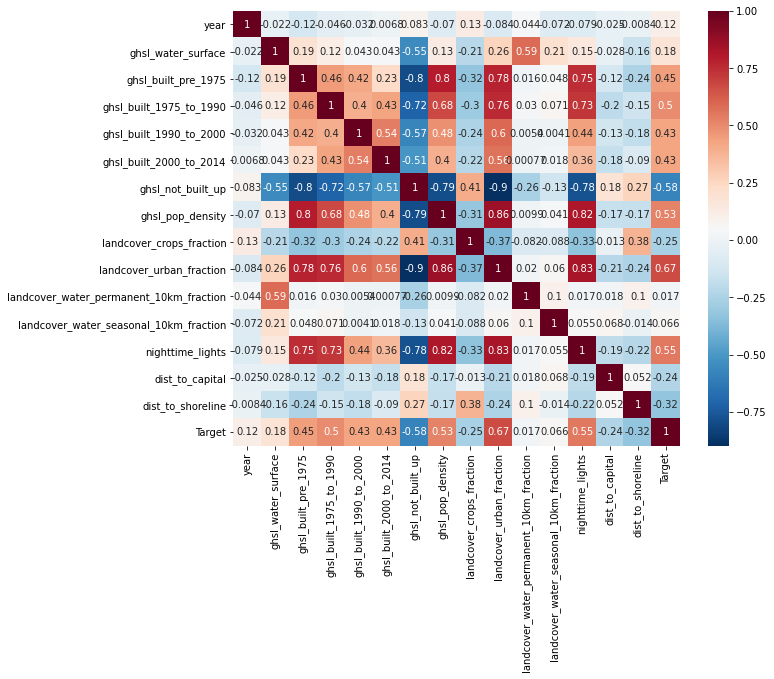

In [18]:
"""
Relationship between numerical features
"""

corrs = train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corrs, cmap='RdBu_r', annot=True)
plt.show()

# Modelling

We've had a look at our data and it looks good! Let's see if we can create a model to predict the Target given some of our inputs. To start with we will use only the numeric columns, so that we can fit a model right away. 

In [19]:
in_cols = list(train.columns[4:-1])
print('Input columns:', in_cols)

Input columns: ['ghsl_water_surface', 'ghsl_built_pre_1975', 'ghsl_built_1975_to_1990', 'ghsl_built_1990_to_2000', 'ghsl_built_2000_to_2014', 'ghsl_not_built_up', 'ghsl_pop_density', 'landcover_crops_fraction', 'landcover_urban_fraction', 'landcover_water_permanent_10km_fraction', 'landcover_water_seasonal_10km_fraction', 'nighttime_lights', 'dist_to_capital', 'dist_to_shoreline']


To evaluate our model, we need to keep some data separate. We will split out data into X (inputs) and y (output) and then further split into train and test sets with the following code:

In [20]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

X, y = train[in_cols], train['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58) # Random state keeps the split consistent
print(X_train.shape, X_test.shape)

(17163, 14) (4291, 14)


We now have a nice test set of ~4200 rows. We will train our model and then use this test set to calculate our score.

In [21]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor() # Create the model
model.fit(X_train, y_train) # Train it (this syntax looks the same for all sklearn models)
model.score(X_test, y_test) # Show a score

0.6971246666077238

What is the score above? The default for regression models is the R^2 score, a measure of how well the mode does at predicting the target. 0.69 is pretty good - let's plot the predictions vs the actual values and see how close it looks to a straight line:

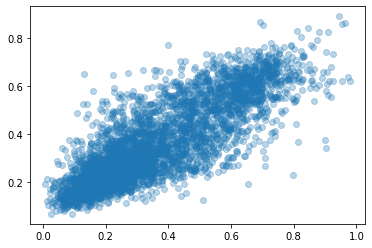

In [22]:
from matplotlib import pyplot as plt
plt.scatter(y_test, model.predict(X_test), alpha=0.3)

This looks great - most predictions are nice and close to the true value! But we still don't have a way to link this to the leaderboard score on Zindi. Let's remedy that by calculating the Root Mean Squared Error, the same metric Zindi uses. 

In [23]:
from sklearn.metrics import mean_squared_error, accuracy_score

# The `squared=False` bit tells this function to return the ROOT mean squared error
mean_squared_error(y_test, model.predict(X_test), squared=False)

0.10843920683468712

Great stuff. Let's make a submission and then move on to looking for ways to improve.

In [24]:
# Copying our predictions into the submission dataframe - make sure the rows are in the same order!
ss['Target'] = model.predict(test[in_cols]) 
ss.head()

,ID,Target
0,ID_AAcismbB,0.161265
1,ID_AAeBMsji,0.164221
2,ID_AAjFMjzy,0.592430
3,ID_AAmMOEEC,0.271751
4,ID_ABguzDxp,0.250287


We now have our predictions in the right format to submit. The following line saves this to a file that you can then upload to get a score:

In [25]:
ss.to_csv('/content/gdrive/MyDrive/Projects/zindi/submissions/randomforest_submission.csv', index=False)

# Getting Better

You might have noticed that your score on Zindi wasn't as good as the one you got above. This is because the test set comes from different countries to the train set. When we did a random split, we ended up with our local train and test both coming from the same countries - and it's easier for a model to extrapolate within countries than it is for it to make predictions for a new location. 

So our first step might be to make a scoring function that splits the data according to country, and measures the model performance on unseen countries. Try it and share your testing methods in the discussions. And look at the following questions:
- Does your score drop when you score your model on countries it wasn't trained with?
- Does the new score more accurately match the leaderboard score?
- Are any countries particularly 'hard' to make predictions in?

In [26]:
# You code for a enw model evaluation method here

def split_by_country(df):
    """take in a dataframe and split into new dataframes by country"""
    d = {}
    val_x = train[train.index.isin(df.index)]
    countries = val_x['country'].unique()
    for country in countries:
        d[f'{country}'] = val_x[val_x['country']==country]
    return d

def model_performance(df_country, model):
    """measure model performance"""
    country = df_country.country.unique()
    kfold = model_selection.KFold(n_splits=5)
    mse = mean_squared_error(df_country['Target'], model.predict(df_country[in_cols]),  squared=False)
    accuracy = model_selection.cross_val_score(model, df_country[in_cols], df_country['Target'], cv=kfold)
    accuracy = accuracy.mean()*100
    country_accuracy = {'country': country[0], 'MSE': mse, 'accuracy': accuracy}
    return country_accuracy

def evaluate_model_per_country(df, model):
    """this function takes a dataframe, splits the data according to country and scores the model by country"""
    j = split_by_country(df)
    scores = []
    for item in j:
        result = model_performance(j[item], model)
        scores.append(result)
    scores_df = pd.DataFrame(scores)
    scores_df.sort_values(by='MSE', inplace=True)
    return scores_df

evaluate_model_per_country(X_test, model)

,country,MSE,accuracy
8,Sierra Leone,0.075683,80.050006
14,Rwanda,0.081859,54.551235
16,Togo,0.087875,65.678765
15,Central African Republic,0.091272,-35.608995
4,Malawi,0.093663,50.669791
2,Lesotho,0.095940,59.886517
10,Cameroon,0.098361,74.633118
9,Senegal,0.103621,67.000532
0,Ethiopia,0.104248,76.136586
3,Mozambique,0.104352,72.437249


Knowing how well our model is doing is useful, but however you measure that we also need ways to improve this performance! There are a few ways to do this:

- Feed the model better data. How? Feature engineering! If we can add meaningful features the model will have more data to work with.
- Tune your models. We used the default parameters - perhaps we can tweak some hyperparameters to make our models better
- Try fancier models. Perhaps XGBoost or a neural network is better than Random Forest at this task

Let's do a little of each. First up, let's create a numeric feature that encodes the 'urban_or_rural' column as something the model can use:

In [27]:
# Turning a categorical column into a numeric feature
train['is_urban'] = (train['urban_or_rural'] == 'U').astype(int)
test['is_urban'] = (test['urban_or_rural'] == 'U').astype(int)
train.head()

,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target,is_urban
0,ID_AAIethGy,Ethiopia,2016,R,0.0,0.000000,0.000000,0.000055,0.000536,0.999408,12.146134,25.489659,0.879484,0.000000,0.000000,0.000000,278.788451,769.338378,0.132783,0
1,ID_AAYiaCeL,Ethiopia,2005,R,0.0,0.000000,0.000110,0.000000,0.000018,0.999872,113.806716,64.136053,0.601427,0.000000,0.005427,0.000000,200.986978,337.135243,0.004898,0
2,ID_AAdurmKj,Mozambique,2009,R,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.400096,0.131900,0.000000,0.003078,0.000000,642.594208,169.913773,0.097320,0
3,ID_AAgNHles,Malawi,2015,R,0.0,0.000141,0.000181,0.000254,0.000228,0.999195,5.213320,25.379371,2.017136,11.293841,0.131035,0.000000,365.349451,613.591610,0.304107,0
4,ID_AAishfND,Guinea,2012,U,0.0,0.011649,0.017560,0.017383,0.099875,0.853533,31.734661,5.081620,22.815984,0.005047,0.130475,1.461894,222.867189,192.926363,0.605328,1



Note that whenever we add features to train, *we also need to add them to test* otherwise we won't be able to make our predictions.

With this extra feature, we can fit a new model:

In [28]:
in_cols.append('is_urban') # Adding the new features to our list of input columns

In [29]:
# Replace this with your chosen method for evaluating a model:
X, y = train[in_cols], train['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58)
model = RandomForestRegressor()
model.fit(X_train, y_train)
mean_squared_error(y_test, model.predict(X_test), squared=False)

0.10457696932607904

Did your score improve?

Next, let's tune our model by adjusting the maximum depth. This is one of many hyperparameters that can be tweaked on a Random Forest model. Here I just try a few randomly chosen values, but you could also use a grid search to try values more methodically.

In [30]:
for max_depth in [3, 5, 8, 10, 14, 18]:
    model = RandomForestRegressor()
    # Again, you van use a better method to evaluate the model here...
    model.fit(X_train, y_train)
    print(max_depth, mean_squared_error(y_test, model.predict(X_test), squared=False))

3 0.10450362948403813
5 0.10426175690591431
8 0.10463907022347284
10 0.1044211731187737
14 0.10424553331308148
18 0.10461018159573353


In this case, it looks like we can improve our performance by specifying a max_depth to limit model complexity.

Finally, let's try a different model out of curiosity:

In [31]:
!pip install catboost

     |████████████████████████████████| 67.3MB 52kB/s 


In [32]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(silent=True)

# Exercise: fit and score the model. Does it beat your other scores? Can you use it to make a submission?

model.fit(X_train, y_train) # Train it (this syntax looks the same for all sklearn models)
model.score(X_test, y_test)


0.7289587344371391

In [33]:
# model performance on catboost regressor
mean_squared_error(y_test, model.predict(X_test), squared=False)

0.10258221870011036

In [34]:
ss['Target'] = model.predict(test[in_cols])
ss.head()

,ID,Target
0,ID_AAcismbB,0.108004
1,ID_AAeBMsji,0.187198
2,ID_AAjFMjzy,0.590742
3,ID_AAmMOEEC,0.396549
4,ID_ABguzDxp,0.256169


In [35]:
ss.to_csv('/content/gdrive/MyDrive/Projects/zindi/submissions/catboost_submission.csv', index=False)

Remember, you can ask questions and share ideas in the discussions. 

### GOOD LUCK!

## XGBoost

In [36]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(objective="reg:squarederror")
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.6987714887379515

In [37]:
"""
Hyperparameter tuning using randomized search
"""

from sklearn.model_selection import RandomizedSearchCV

# Define the parameters to search over
param_grid = {
    "n_estimators": [100, 500, 900, 1100, 1500],
    "base_score": [0.25,0.5,0.75,1],
    "learning_rate": [0.05, 0.1, 0.15, 0.20],
    "max_depth": [3, 5, 7, 10],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9]
}

# Setup the grid search
grid = RandomizedSearchCV(xgb_model,
                    param_grid,
                    cv=5,
                    verbose=5,
                    n_jobs=4,
                    return_train_score=True,
                    random_state=58)

# Fit the grid search to the data
grid.fit(X, y)

# Find the best parameters
grid.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 12.1min finished


{'base_score': 0.5,
 'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 500,
 'subsample': 0.7}

In [38]:
xgb_model_ideal = XGBRegressor(base_score=0.5, colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=500, subsample=0.7, objective="reg:squarederror")
xgb_model_ideal.fit(X_train, y_train)
xgb_model_ideal.score(X_test, y_test)

0.7243373389247805

In [39]:
mean_squared_error(y_test, xgb_model_ideal.predict(X_test), squared=False)

0.10345306257756934

In [40]:
ss['Target'] = xgb_model_ideal.predict(test[in_cols])
ss.head()

,ID,Target
0,ID_AAcismbB,0.136217
1,ID_AAeBMsji,0.197354
2,ID_AAjFMjzy,0.619477
3,ID_AAmMOEEC,0.402201
4,ID_ABguzDxp,0.283660


In [41]:
ss.to_csv('/content/gdrive/MyDrive/Projects/zindi/submissions/xgb_submission.csv', index=False)

In [42]:
evaluate_model_per_country(X_test, xgb_model_ideal)

,country,MSE,accuracy
14,Rwanda,0.073565,66.190015
8,Sierra Leone,0.073692,79.765564
16,Togo,0.085769,66.679277
4,Malawi,0.088812,58.377120
10,Cameroon,0.092400,75.686265
2,Lesotho,0.092752,62.866402
0,Ethiopia,0.096916,83.939991
9,Senegal,0.099366,70.911123
3,Mozambique,0.101835,73.227861
15,Central African Republic,0.104030,18.615247


## ANN Model


In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

### Tuning the ANN model


#### tuning the number of layers and neurons


In [44]:
pip install keras-tuner

     |████████████████████████████████| 71kB 4.1MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=600a84601926c03dccdbf113644c3f6a32fdc4b1c18185ca809321cd216a2c63
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=765a69791b747ad5895648276f96a41d110546a08bda134522d6f685b90d177a
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [45]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    return model

In [46]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=5,
    executions_per_trial=3,
    directory='/content/gdrive/MyDrive/Projects/zindi',
    project_name='Wealth prediction index')

INFO:tensorflow:Reloading Oracle from existing project /content/gdrive/MyDrive/Projects/zindi/Wealth prediction index/oracle.json
INFO:tensorflow:Reloading Tuner from /content/gdrive/MyDrive/Projects/zindi/Wealth prediction index/tuner0.json


In [47]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test),
             objective='val_loss',
             max_trials=5,
             executions_per_trial=3)

INFO:tensorflow:Oracle triggered exit


In [48]:
tuner.results_summary()

Results summary
Results in /content/gdrive/MyDrive/Projects/zindi/Wealth prediction index
Showing 10 best trials
Objective(name='val_mean_squared_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 3
units_0: 320
units_1: 512
learning_rate: 0.01
units_2: 320
units_3: 320
units_4: 192
units_5: 96
units_6: 512
units_7: 288
units_8: 512
units_9: 160
units_10: 256
units_11: 320
units_12: 384
units_13: 256
units_14: 192
units_15: 64
units_16: 224
Score: 3.773672870011069e-05
Trial summary
Hyperparameters:
num_layers: 17
units_0: 128
units_1: 448
learning_rate: 0.01
units_2: 480
units_3: 96
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
units_11: 32
units_12: 32
units_13: 32
units_14: 32
units_15: 32
units_16: 32
Score: 5.431997730435493e-05
Trial summary
Hyperparameters:
num_layers: 14
units_0: 224
units_1: 128
learning_rate: 0.0001
units_2: 192
units_3: 288
units_4: 64
units_5: 352
units_6: 64
units_7: 96
units_8: 160
units_9: 512
units

One of the models with the best trials had a mean squared error of **0.00018561543159497282**. Its parameters were:

*   **4** layers
*   learning rate of **0.0001**
* layer 1: 160
* layer 2: 384
* layer 3: 96
* layer 4: 32
</br>

We will use this model to determine params for our epoch and batch size



In [49]:
# Create a KerasRegressor

from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam

n_cols = X.shape[1]
input_shape = (n_cols, )

def create_model(learning_rate = 0.0001, activation = 'relu'):
  # Use Adam optimizer with the given learning rate
  opt = Adam(lr = learning_rate)

  # create model
  model = Sequential()
  model.add(Dense(160, activation=activation, input_dim = X.shape[1]))
  model.add(Dense(384, activation=activation))
  model.add(Dense(96, activation=activation))
  model.add(Dense(32, activation=activation))
  model.add(Dense(1, activation='linear'))

  # compile model
  model.compile(optimizer = opt,
                loss = "mean_absolute_error",
                metrics=['mse', "mae"])
  
  return model

model = KerasRegressor(build_fn = create_model,
                       verbose = 0)

In [50]:
# Hyperparameter tuning using randomized search

params = {'batch_size': [8, 16, 24, 32, 40, 56]}

grid = RandomizedSearchCV(model, param_distributions=params, cv=5, verbose=5, n_jobs=4, return_train_score=True, random_state=58)

# Fit the grid search to the data
grid.fit(X, y)

# Find the best parameters
grid.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  2.0min finished
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


{'batch_size': 32}

In [60]:
# Train model with best params

from numpy.random import seed

# setting the seed
seed(58)
tf.random.set_seed(58)

# early stopping
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

ann_model_ideal = create_model()
ann_model_ideal_history = ann_model_ideal.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=8, epochs=600, callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/600
2146/2146 [==============================] - 7s 3ms/step - loss: 1.1192 - mse: 6.1370 - mae: 1.1192 - val_loss: 1.1113 - val_mse: 1.9922 - val_mae: 1.1113
Epoch 2/600
2146/2146 [==============================] - 6s 3ms/step - loss: 0.6115 - mse: 0.8582 - mae: 0.6115 - val_loss: 0.4186 - val_mse: 0.2877 - val_mae: 0.4186
Epoch 3/600
2146/2146 [==============================] - 6s 3ms/step - loss: 0.3599 - mse: 0.2726 - mae: 0.3599 - val_loss: 0.4884 - val_mse: 0.3419 - val_mae: 0.4884
Epoch 4/600
2146/2146 [==============================] - 7s 3ms/step - loss: 0.3266 - mse: 0.2185 - mae: 0.3266 - val_loss: 0.4063 - val_mse: 0.2412 - val_mae: 0.4063
Epoch 5/600
2146/2146 [==============================] - 7s 3ms/step - loss: 0.2409 - mse: 0.1208 - mae: 0.2409 - val_loss: 0.4660 - val_mse: 0.3496 - val_mae: 0.4660
Epoch 6/600
2146/2146 [==============================] - 6s 3ms/step - loss: 0.2054 - mse: 0.0816 - mae: 0.2054 - val_loss: 0.3723 - val_mse: 0.2143 - val_mae: 0.372

In [61]:
# model performance on ANN
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, ann_model_ideal.predict(X_test), squared=False)

0.11102793888092503

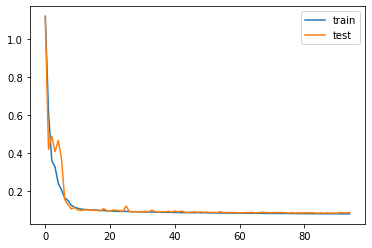

In [62]:
plt.plot(ann_model_ideal_history.history['loss'], label='train')
plt.plot(ann_model_ideal_history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [63]:
ss['Target'] = ann_model_ideal.predict(test[in_cols])
ss.head()

,ID,Target
0,ID_AAcismbB,0.154825
1,ID_AAeBMsji,0.177139
2,ID_AAjFMjzy,0.643263
3,ID_AAmMOEEC,0.369632
4,ID_ABguzDxp,0.215336


In [55]:
ss.to_csv('/content/gdrive/MyDrive/Projects/zindi/submissions/ann_submission.csv', index=False)